## evaluate_UNET_Selina - ROC-Curve


In this notebook we apply the previously trained model to a set of images and evaluate the quality of the prediction.

This includes the following steps:

* load the original dataset
* prerpocess the dataset (zero center, normalize to range -1 to 1)
* feed the data to the model
* find the ellipses in the predicted likelihood image
* match pairs of predicted and original ellipses
* calculate quality measures
* calculate tpr and fpr for different thresholds

### ROC-Curve
receiver operating characteristic curve means plotting the true positive rate (TPR) against the false positive rate (FPR) for various thresholds.

TPR is also known as the sensitivity/recall of the model
$$ TPR = \frac{TP}{P}$$, where TP is the number of GT ellipses detected by the network and P the total number of GT ellipses.

FPR is the probability of false alarm

$$FPR = \frac{FP}{N} = \frac{FP}{FP + TN} = 1 - TNR$$

Since we do not know the total amount of negatives, we have to normalize the data as $FPR = \frac{FP}{max(FP)}$. This allows us to compare the data.

In [1]:
!ls /tf/results/models/

Unet_0-0-0.h5		       Unet_0-0-4_20200423-075700.h5
Unet_0-0-0_20200411-124102.h5  Unet_0-0-4_20200423-093523.h5
Unet_0-0-1.h5		       Unet_0-0-5_fl_RAda,_20200507-094138.h5
Unet_0-0-1_20200411-120615.h5  Unet_0-0-5_fl_RAdam_20200426-134706.h5
Unet_0-0-1_20200411-122810.h5  Unet_0-0-5_fl_RAdam_20200512-094113.h5
Unet_0-0-1_20200411-132132.h5  Unet_0-0-5_fl_RAdam_20200522-122844.h5
Unet_0-0-1_20200413-105017.h5  Unet_0-0-5_fl_RAdam_20200525-084831.h5
Unet_0-0-2_20200413-190741.h5  Unet_0-0-5_fl_RAdam_20200602-100339.h5
Unet_0-0-3_20200414-144612.h5  Unet_0-0-5_fl_RAdam_20200602-115253.h5
Unet_0-0-4_20200423-064224.h5  Unet_0-0-5_fl_RAdam_20200603-153056.h5
Unet_0-0-4_20200423-070809.h5  Unet_0-0-5_fl_RAdam_20200610-140630.h5
Unet_0-0-4_20200423-070930.h5  Unet_0-0-5_fl_RAdam_20200610-141144.h5
Unet_0-0-4_20200423-071031.h5  Unet_0-0-5_fl_RAdam_20200615-152004.h5
Unet_0-0-4_20200423-071209.h5  Unet_0-0-5_fl_RAdam_20200615-191423.h5
Unet_0-0-4_20200423-071259.h5  Unet_0-0-5_fl_RAdam_20200

In [2]:
import tensorflow as tf
# TODO: remove after tf2.0 migration
# handle tf API changes 1.x to 2.0
from packaging import version
if version.parse(tf.__version__) < version.parse('2.0'):
    opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=opts))
else:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
## check if tf detected a GPU 
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x for x in local_device_protos if x.device_type == 'GPU']



print("GPU device id: ", tf.test.gpu_device_name())
print("GPU details: \n" , get_available_gpus())

1 Physical GPUs, 1 Logical GPUs
GPU device id:  /device:GPU:0
GPU details: 
 [name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 137887744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 525102523322067038
physical_device_desc: "device: 0, name: Quadro M4000, pci bus id: 0000:65:00.0, compute capability: 5.2"
]


In [3]:
## load the UNet model from UNETmodel.py
# details the the network can be found here: 
from includes.UNETmodel import UNet

# create model takes two arguments, the dimension of the input image (width x height x channels)
# and the number of classes 
# TODO: check if the last activation function is correctly choosen in this implementation!
with tf.device('/cpu:0'):
    #unet = UNet().create_model((540,300,1),1, d=32)
    #unet.load_weights("/tf/results/models/Unet_0-0-1_20200413-105017.h5")
    
    unet = UNet().create_model((720,540,1), 1 , d=8)
    unet.load_weights("/tf/results/models/Unet_0-0-5_fl_RAdam_20200610-141144.h5")

network = 'Cell_contours_evaluation_data_'

build UNet ...


In [4]:
#### Copied Training setup
from datetime import datetime

test_size = 0.2
random_state = 121
epochs = 100
batch_size = 4
learning_rate = 1e-5
loss = 'binary_crossentropy'
metrics = ['accuracy']
stats = dict(
    name="Unet",
    version="0-0-1",
    date=datetime.now().strftime('%Y%m%d-%H%M%S'),
    data_raw="-".join(["M1p1","M1p2","M1p3"]),
    data_split="%d-%d"%(test_size*100, random_state),
    model_path="/tf/results/results/models/",
    model_ext="h5",
    log_path="/tf/results/results/logs/",
    img_path="/tf/results/results/singlePredictions/"
)

## Convert mask to ellipse
There are 2 steps to perform. The first is the conversion from a binary mask to individual object edges. We achieve this by the scikit-image methods **label**, which enumerates the individual patches of objects within the mask.
In the second step we apply the function **regionprops** to the pixel positions of the mask edge pixels.

In [5]:
from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import binary_erosion
import cv2
import os
import imageio
import numpy as np

def fit_ellipses_regionprops(p):
    labeled = label(p)
    out = []
    for region in regionprops(labeled,p):  
        if region.area >= 100: #analyze only regions larger than 100 pixels
        #if region.area >= Amin_pixels:
            fit = ((region.centroid[0],region.centroid[1]),(region.minor_axis_length,region.major_axis_length),90 - np.rad2deg(-region.orientation))
            out.append(fit)
    return out

In [6]:
def preprocess(img):
    return (img - np.mean(img)) / np.std(img).astype(np.float32)

## Show results for individual image
We apply the network to the image with the number "id" in the clickpoints database.
We plot the original image, the predicted likelihood, the human expert mask and the prediction mask.<br>
We alpha overlay this with the fitted ellipses from the prediction mask image in red.

In [ ]:
# load the training images and masks
import os
import imageio
import numpy as np
search_path = '../results/cell_contour/evaluate'
images = []
masks = []

for root, dirs, files in os.walk(search_path):
    for file in files:
        if not file.endswith(".tif"):
            continue
        imgfile_path = os.path.abspath(os.path.join(root, file))
        maskfile_path = imgfile_path.replace("/New_Evaluate_Images/", "/New_Evaluate_Masks/")
        
        if not os.path.isfile(maskfile_path):
            continue
        img = imageio.imread(imgfile_path)
        if len(img.shape) == 3:
            img = img[:,:,0]
        images.append(np.array(preprocess(img))[:,:,None])
        masks.append(np.array(imageio.imread(maskfile_path), dtype=np.float32)[:,:,None]/255.)
images = np.asarray(images)
masks = np.asarray(masks)

print(images.shape)
print(masks.shape)

In [ ]:
id=5
#21, 23 hat Halo

with tf.device('/cpu:0'):
    prediction=unet.predict(images[id:id+1])
    
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

#Canny-filter
from skimage import feature
from scipy.ndimage import morphology
struct = morphology.generate_binary_structure(2, 1)  #structural element for binary erosion


pred = prediction[0]
print(np.shape(pred))

im1o = feature.canny(images[id].squeeze(), sigma=2.5, low_threshold=0.6, high_threshold=0.99, use_quantiles=True) #edge detection           
im2o = morphology.binary_fill_holes(im1o, structure=struct).astype(int) #fill holes
im3o = morphology.binary_erosion(im2o, structure=struct).astype(int) #erode to remove lines and small dirt
ellipses_n = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(im3o)])

fig, axes = plt.subplots(1,4,figsize=[16,5],)
ax=axes[0]
ax.set_title("original")
ax.imshow(images[id].squeeze())
ax.set_axis_off()

ax=axes[1]
ax.set_title("human expert mask")
ax.imshow(masks[id].squeeze())
ax.set_axis_off()

ax=axes[2]
ax.set_title("Canny filter [binary]]")
ax.imshow(im3o.squeeze())
ax.set_axis_off()

for ell in fit_ellipses_regionprops(im3o.squeeze()):
    xy, (a,b), phi = ell
    e = Ellipse([xy[1],xy[0]], width=b,height=a, angle=-phi, fill=True, edgecolor = 'b',linestyle='--')
    ax.add_artist(e)
    e.set_alpha(0.5)
    e.set_facecolor((1.,0.,0.))
    #e.set_edgecolor(('r'))

ax=axes[3]
ax.set_title("prediction mask [binary]")
ax.imshow(pred.squeeze()>0.5)
ax.set_axis_off()

for ell in fit_ellipses_regionprops(prediction.squeeze()>0.5):
    xy, (a,b), phi = ell
    e = Ellipse([xy[1],xy[0]], width=b,height=a, angle=-phi, fill=True, edgecolor = 'b',linestyle='--')
    ax.add_artist(e)
    e.set_alpha(0.5)
    e.set_facecolor((1.,0.,0.))
    #e.set_edgecolor(('r'))
    #print(np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(prediction.squeeze()>0.5)]))
    
np.shape(prediction.squeeze())

## Apply to all images
We apply the network to all images. Most of the code is handling of file paths and Database entries to get the prediction to the correct img. The actual ellipse prediction for raw image **img** is:
```python
prediction_mask =unet.predict(img[None,:,:,0,None].astype(np.float32)/255.).squeeze()>0.5
ellipses_n = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(prediction_mask)])
```
We match the predicted ellipses to the original ones, enabling us to calculate evaluation metrics. For this we use the euclidian distance between a **ground truth** (manual acquired) ellipse and a **system** (redicted by network + regionprops) ellipse center as the cost of matching this pair. We match via the **linear_sum_assignment** function implemented in scipy, which builts up on the "hungarian algorithm" by Kuhn and Munkres [Kuhn55].<br>
Additionaly, the center distance has to be below 50 pixels.<br>
We save the predicted and ground truth ellipses in arrays for the neural network and the ground truth and sepatate array for the matched ellipses.
<br><br>
H. W. Kuhn (1955): The Hungarian method for the assignment problem. Naval Research Logistics Quarterly 2, S. 83–97.

In [7]:
import os
import clickpoints
import numpy as np
from scipy.optimize import linear_sum_assignment
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

from skimage.draw import ellipse       # generate binary mask
from matplotlib.path import Path

# change this path to do the evaluation for the training data
search_path = '../results/cell_contours/evaluate'
file_list = []
for root, dirs, files in os.walk(search_path):
    for file in files:
        if not file.endswith(".cdb"):
            continue
        file_list.append(os.path.abspath(os.path.join(root, file)))
# all cdb files with images and ellipses

len_tot = 0

Trues = []
TP = []
FN = []
FP = []
precision = []
TPR = []
F1 = []
num_cells = 0

nx, ny = 540,720
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T

#Thresholds = np.arange(0.1,1,0.1)
Thresholds = list(np.arange(0.1,1,0.1)) + list(np.arange(0.91,1,0.01))
Thresholds = np.array(Thresholds)


area_too_small = []
overlap = []
num_overlap = []

for threshold in Thresholds:
    print('New threshold: {}'.format(threshold))
    GT = []  # Manually acquired ellipses
    GTMatchR = []
    SysMatchR = []  # System ellipses (regionprops) with matching ellipses
    SysR = []  # By system acquired (regionprops)
    
    for cdb_file in file_list[0:4]:
        cdb = clickpoints.DataFile(cdb_file)
        
        q_poly = cdb.getPolygons()
        print("#%d found" % q_poly.count())

        # get the image ids which contain at least on polygon # in ground truth
        img_ids = np.unique([el.image.id for el in q_poly])
        #print(img_ids)
        
        # How many images in cdb
        q_img = cdb.getImages()
        ids = np.unique([i.id for i in q_img])
        print("#%d images" % len(ids))
        #print(len(ids))
        len_tot += len(ids)
        area = 0
        
        for id in ids:
            # get image object by id and image data
            img_o = cdb.getImage(id=id)
            img   = img_o.get_data()
            if len(img.shape) == 3:
                img = img[:,:,0]
            with tf.device('/cpu:0'):
                im = preprocess(img[None,:,:,None])
                prediction_mask = unet.predict(im).squeeze() > threshold
                ellipses_r = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(prediction_mask)])

            SysR.extend(ellipses_r)
            # get ellipses in this image 
            
            if id in img_ids:
                nx, ny = 540,720
                x, y = np.meshgrid(np.arange(nx), np.arange(ny))
                x, y = x.flatten(), y.flatten()
                points = np.vstack((x,y)).T

                mask = np.zeros((img.shape[0:2]), dtype=np.uint8)
                q_polys=cdb.getPolygons(image=img_o)
                for pol in q_polys:
                    if np.shape(pol)[0] != 0:
                        num_cells += 1
                        polygon = np.array([pol.points])
                        path = Path(polygon.squeeze())
                        grid = path.contains_points(points)
                        grid = grid.reshape((ny,nx))
                        mask += grid

                ellipses_o = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(mask)])
                GT.extend(ellipses_o)

                ### Try matching with GT ###
                #print('GT and prediction comparison')           
                if np.shape(ellipses_r)[0] != 0 and np.shape(ellipses_o)[0] != 0:    
                    costR = np.linalg.norm(ellipses_o[None,:,:2]-ellipses_r[:,None,:2], axis=-1)
                    sys_ids_r, gt_ids_r = linear_sum_assignment(costR)     

                    #print(sys_ids_r)
                    # costR has to be under a certain value. Centers have to be at closer than 50 pixels apart
                    index = []
                    for i in range(len(sys_ids_r)):
                        if costR[sys_ids_r[i],gt_ids_r[i]] > 50:
                            #print('Here R')
                            #print(sys_ids_r,gt_ids_r, costR)
                            index.append(i)
                            
                    sys_ids_r = np.delete(sys_ids_r,index)
                    gt_ids_r = np.delete(gt_ids_r,index)
                    #print(sys_ids_r)
                    #print(sys_ids_r,gt_ids_r)
                    len_before = len(sys_ids_r)
                    # We just accept ellipses that have a min area overlap of 0.7 area of GT ellipse
                    index = []
                    for i in range(len(sys_ids_r)):
                        el=ellipses_o[gt_ids_r[i]]
                        mask_o = np.zeros((np.shape(img)[0:2]), dtype=np.uint8)
                        ys,xs = ellipse(el[0], el[1],  el[2]/2, el[3]/2, rotation=np.deg2rad(el[4]))
                        for n in range(len(xs)):
                            if xs[n]<720 and ys[n] < 540:
                                mask_o[xs[n],ys[n]] = 1
                        el=ellipses_r[sys_ids_r[i]]
                        mask_r = np.zeros((np.shape(img)[0:2]), dtype=np.uint8)
                        ysr,xsr = ellipse(el[0], el[1],  el[2]/2, el[3]/2, rotation=np.deg2rad(el[4]))
                        for n in range(len(xsr)):
                            if xsr[n]<720 and ysr[n] < 540:
                                mask_r[xsr[n],ysr[n]] = 1
                        overlap.append(np.sum(mask_o * mask_r) / np.sum(mask_o))

                        if np.sum(mask_o * mask_r) < 0.7 * np.sum(mask_o):
                            index.append(i)
                            area += 1
                    sys_ids_r = np.delete(sys_ids_r,index)
                    gt_ids_r = np.delete(gt_ids_r,index)
                    len_after = len(sys_ids_r)

                    GTMatchR.extend(ellipses_o[gt_ids_r])
                    SysMatchR.extend(ellipses_r[sys_ids_r])
    
    area_too_small.append(area)
    print(area_too_small)
    
    plt.plot(overlap,'o')
    num_overlap.append(len(overlap))
    
    GT=np.array(GT)

    # Matched ellipses with regionprops
    GTMatchR=np.array(GTMatchR)
    SysR=np.array(SysR)
    SysMatchR=np.array(SysMatchR)

    print('Threshold: {}'.format(threshold))

    print(np.shape(GT))

    print('GT and SysR')
    print(np.shape(GTMatchR))
    print(np.shape(SysR))
    print(np.shape(SysMatchR))

    Trues.append(np.shape(GT)[0])
    print('total true: {}'.format(Trues[-1]))

    TP.append(np.shape(SysMatchR)[0])
    FN.append(np.shape(GT)[0] - np.shape(SysMatchR)[0])
    FP.append(np.shape(SysR)[0] - np.shape(SysMatchR)[0])

    print('TP = {} ,FN = {} ,FP = {}'.format(TP[-1],FN[-1],FP[-1]))
    precision.append(TP[-1] / (TP[-1] + FP[-1]))
    TPR.append(TP[-1] / (TP[-1] + FN[-1]))
    try:
        F1.append((2 * precision[-1] * TPR[-1]) / (precision[-1] + TPR[-1]))
    except:
        F1.append(0)
    print('Neural Network + Regionprops: \n precision = %.4f, recall = %.4f, F1-score = %.4f' % (precision[-1], TPR[-1], F1[-1]))

print('Done!')

no openslide found
New threshold: 0.1
path /tf/results/cell_contours/evaluate/gt_2_ben.cdb
Open database with version 22
#371 found
#500 images
[1]
Threshold: 0.1
(369, 5)
GT and SysR
(364, 5)
(1371, 5)
(364, 5)
total true: 369
TP = 364 ,FN = 5 ,FP = 1007
Neural Network + Regionprops: 
 precision = 0.2655, recall = 0.9864, F1-score = 0.4184
New threshold: 0.2
path /tf/results/cell_contours/evaluate/gt_2_ben.cdb
Open database with version 22
#371 found
#500 images
[1, 2]
Threshold: 0.2
(369, 5)
GT and SysR
(365, 5)
(860, 5)
(365, 5)
total true: 369
TP = 365 ,FN = 4 ,FP = 495
Neural Network + Regionprops: 
 precision = 0.4244, recall = 0.9892, F1-score = 0.5940
New threshold: 0.30000000000000004
path /tf/results/cell_contours/evaluate/gt_2_ben.cdb
Open database with version 22
#371 found
#500 images
[1, 2, 11]
Threshold: 0.30000000000000004
(369, 5)
GT and SysR
(355, 5)
(669, 5)
(355, 5)
total true: 369
TP = 355 ,FN = 14 ,FP = 314
Neural Network + Regionprops: 
 precision = 0.5306, recal

In [9]:
network = 'new'

# Visualize the effect of the area overlap criterion

The match is only accepted if the area overlap is bigger than 0.7.

If that is not the case, the ellipse is considered a false positive instead of a true positive.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


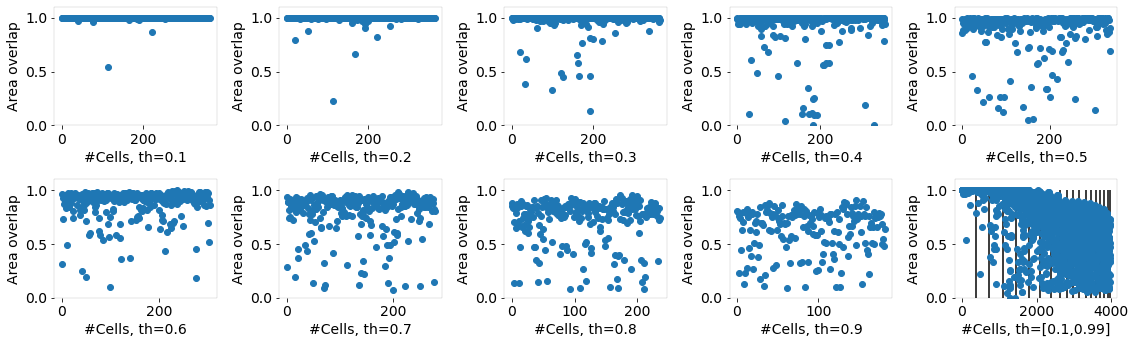

In [9]:
#dev_1 = overlap[num_overlap[9] + 1:num_overlap[10]]
#dev_2 = overlap[num_overlap[10] + 1:num_overlap[11]]
#dev_3 = overlap[num_overlap[11] + 1:num_overlap[12]]
#dev_4 = overlap[num_overlap[12] + 1:num_overlap[13]]
#dev_5 = overlap[num_overlap[13] + 1:num_overlap[14]]
#dev_6 = overlap[num_overlap[14] + 1:num_overlap[15]]
#dev_7 = overlap[num_overlap[15] + 1:num_overlap[16]]
#dev_8 = overlap[num_overlap[16] + 1:num_overlap[17]]
#dev_9 = overlap[num_overlap[17] + 1:num_overlap[18]]

font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=18)    
plt.rcParams['axes.linewidth'] = 0.1 #set the value globally


dev_1 = overlap[:num_overlap[0]]
dev_2 = overlap[num_overlap[0] + 1:num_overlap[1]]
dev_3 = overlap[num_overlap[1] + 1:num_overlap[2]]
dev_4 = overlap[num_overlap[2] + 1:num_overlap[3]]
dev_5 = overlap[num_overlap[3] + 1:num_overlap[4]]
dev_6 = overlap[num_overlap[4] + 1:num_overlap[5]]
dev_7 = overlap[num_overlap[5] + 1:num_overlap[6]]
dev_8 = overlap[num_overlap[6] + 1:num_overlap[7]]
dev_9 = overlap[num_overlap[7] + 1:num_overlap[8]]

#dev_111 = overlap[num_overlap[-1] + 1:num_overlap[-2]]

fig, axes = plt.subplots(2,5,figsize=[16,5],)
axes=np.array(axes)

ax = axes[0,0]
ax.plot(dev_1,'o')
ax.set_xlabel("#Cells, th=0.1")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[0,1]
ax.plot(dev_2,'o')
ax.set_xlabel("#Cells, th=0.2")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[0,2]
ax.plot(dev_3,'o')
ax.set_xlabel("#Cells, th=0.3")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[0,3]
ax.plot(dev_4,'o')
ax.set_xlabel("#Cells, th=0.4")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[0,4]
ax.plot(dev_5,'o')
ax.set_xlabel("#Cells, th=0.5")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[1,0]
ax.plot(dev_6,'o')
ax.set_xlabel("#Cells, th=0.6")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[1,1]
ax.plot(dev_7,'o')
ax.set_xlabel("#Cells, th=0.7")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[1,2]
ax.plot(dev_8,'o')
ax.set_xlabel("#Cells, th=0.8")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[1,3]
ax.plot(dev_9,'o')
ax.set_xlabel("#Cells, th=0.9")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

from matplotlib.pyplot import vlines
ax = axes[1,4]
ax.plot(overlap,'o')
ax.set_xlabel("#Cells, th=[0.1,0.99]")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)
ax.vlines(num_overlap,0,1)

fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/' + network + 'area_overlaps' + '.png')

In [17]:
print(Thresholds)

[0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.91 0.92 0.93 0.94 0.95
 0.96 0.97 0.98 0.99]


[7.29394602e-04 2.32558140e-03 1.64424514e-02 4.04929577e-02
 6.04166667e-02 7.07317073e-02 1.32394366e-01 2.06405694e-01
 4.31279621e-01 4.44444444e-01 4.42105263e-01 5.13661202e-01
 5.91194969e-01 5.90277778e-01 6.76923077e-01 7.11864407e-01
 8.04123711e-01 8.66666667e-01]


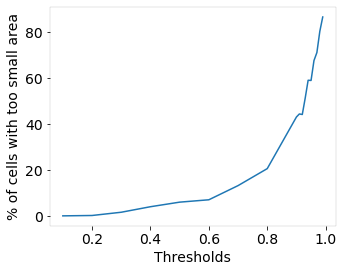

In [17]:
font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=18)    
plt.rcParams['axes.linewidth'] = 0.1 #set the value globally


Trues = np.array(Trues)
FP = np.array(FP)
TP = np.array(TP)

print(area_too_small/(FP + TP))

fig, ax = plt.subplots(figsize=[5,4])

plt.plot(Thresholds,area_too_small/(FP + TP)*100)
plt.xlabel('Thresholds')
plt.ylabel('% of cells with too small area')
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/' + network + 'area_too_small' + '.png')

## Plot ROC-Curve

plot of TPR vs FPR for different thresholds

[0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.91 0.92 0.93 0.94 0.95
 0.96 0.97 0.98 0.99]
[0.986449864498645, 0.989159891598916, 0.962059620596206, 0.9105691056910569, 0.8428184281842819, 0.7479674796747967, 0.6341463414634146, 0.4878048780487805, 0.25203252032520324, 0.24119241192411925, 0.23306233062330622, 0.1897018970189702, 0.13821138211382114, 0.12466124661246612, 0.08672086720867209, 0.07046070460704607, 0.03523035230352303, 0.016260162601626018]
[1007  495  314  232  169  134  121  101  118  109  104  113  108   98
   98   92   84   54]
[364 365 355 336 311 276 234 180  93  89  86  70  51  46  32  26  13   6]


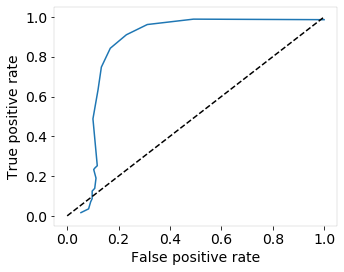

In [12]:
import matplotlib.pyplot as plt
print(Thresholds)
print(TPR)
print(FP)
print(TP)
fig, ax = plt.subplots(figsize=[5,4])

FPR = FP/(np.max(FP))
plt.plot(FPR,TPR)
plt.plot([0,1],[0,1],'k--')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/ROC_' + network + '.png')

In [33]:
from numpy import trapz
area = trapz(TPR, FPR)
print(-area)
print(np.max(TPR))
-area/np.max(TPR)

0.8554199196411031
0.989159891598916


0.8647943845138822

Total area: 367555.0
AUC: 317859.5
AUC relative: 0.86479


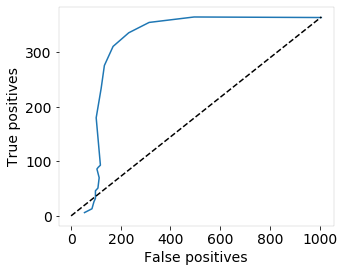

In [19]:
fig, ax = plt.subplots(figsize=[5,4])

plt.plot(FP,TP)
plt.xlabel('False positives')
plt.ylabel('True positives')
plt.plot([0,np.max(FP)],[0,np.max(TP)],'k--')
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/roc_absolute_' + network + '.png')
area_total = (np.max(TP) * np.max(FP))
print('Total area: %.1f' % area_total)
area2 = -trapz(TP, FP)
print('AUC: %.1f' % area2)
print('AUC relative: %.5f' % (area2/area_total))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


169 0.16782522343594836
311 0.8428184281842819
0.6479166666666667
0.8428184281842819
0.7326266195524146
0.5


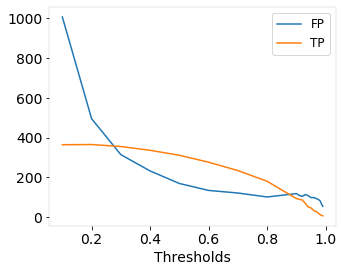

In [20]:
fig, ax = plt.subplots(figsize=[5,4])
plt.plot(Thresholds,FP)
plt.plot(Thresholds,TP)
plt.xlabel('Thresholds')
plt.legend(['FP','TP'],loc=1)
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/tp_fp_absolute_' + network + '.png')
print(FP[4], FPR[4])
print(TP[4], TPR[4])
print(precision[4])
print(TPR[4])
print(F1[4])
print(Thresholds[4])

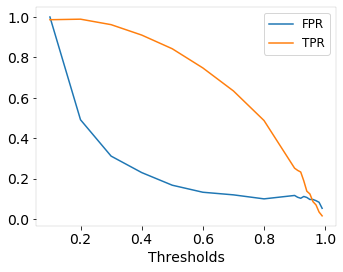

In [21]:
fig, ax = plt.subplots(figsize=[5,4])
plt.plot(Thresholds,FPR)
plt.plot(Thresholds,TPR)
plt.xlabel('Thresholds')
plt.legend(['FPR','TPR'],loc=1)
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/tpr_fpr_' + network + '.png')

0.2556864248124254


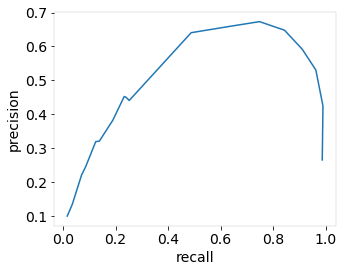

In [22]:
fig, ax = plt.subplots(figsize=[5,4])
plt.plot(TPR, precision)
plt.xlabel('recall')
plt.ylabel('precision')
fig.tight_layout()

plt.savefig('/tf/results/results_new/ROC/ROC_curve/precision_recall_' + network + '.png')

area = trapz(TPR, precision)
print(area)

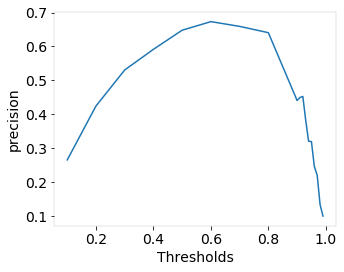

In [23]:
fig, ax = plt.subplots(figsize=[5,4])
plt.plot(Thresholds,precision)
plt.xlabel('Thresholds')
plt.ylabel('precision')
fig.tight_layout()
#plt.savefig('/tf/results/results_new/ROC/ROC_curve/precision_' + network + '.png')

Text(0, 0.5, 'recall')

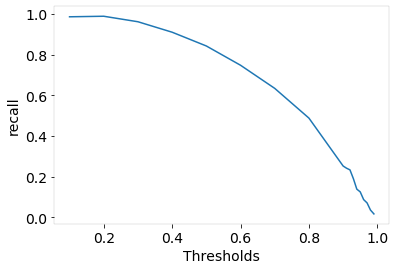

In [24]:
plt.plot(Thresholds,TPR)
plt.xlabel('Thresholds')
plt.ylabel('recall')
#plt.savefig('/tf/results/results_new/ROC/ROC_curve/recall_' + network + '.png')

[0.986449864498645, 0.989159891598916, 0.962059620596206, 0.9105691056910569, 0.8428184281842819, 0.7479674796747967, 0.6341463414634146, 0.4878048780487805, 0.25203252032520324, 0.24119241192411925, 0.23306233062330622, 0.1897018970189702, 0.13821138211382114, 0.12466124661246612, 0.08672086720867209, 0.07046070460704607, 0.03523035230352303, 0.016260162601626018]
[0.26549963530269877, 0.42441860465116277, 0.5306427503736921, 0.5915492957746479, 0.6479166666666667, 0.6731707317073171, 0.6591549295774648, 0.6405693950177936, 0.44075829383886256, 0.4494949494949495, 0.45263157894736844, 0.3825136612021858, 0.32075471698113206, 0.3194444444444444, 0.24615384615384617, 0.22033898305084745, 0.13402061855670103, 0.1]


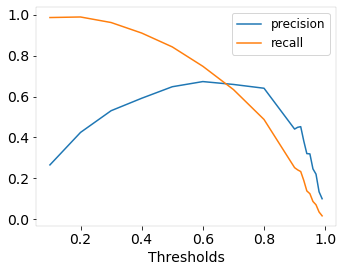

In [25]:
fig, ax = plt.subplots(figsize=[5,4])
plt.plot(Thresholds,precision)
plt.plot(Thresholds,TPR)
plt.xlabel('Thresholds')
plt.legend(['precision','recall'],loc=1)
print(TPR)
print(precision)
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/p_vs_r_' + network + '.png')

Text(0, 0.5, 'FPR')

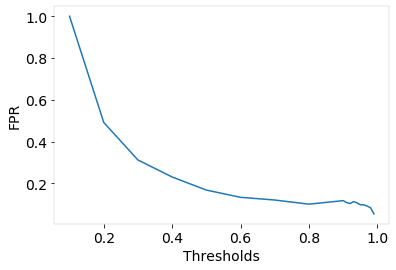

In [26]:
plt.plot(Thresholds,FPR)
plt.xlabel('Thresholds')
plt.ylabel('FPR')
#plt.savefig('/tf/results/results_new/ROC/ROC_curve/FPR_' + network + '.png')

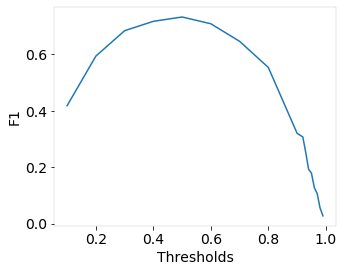

In [27]:
fig, ax = plt.subplots(figsize=[5,4])
plt.plot(Thresholds,F1)
plt.xlabel('Thresholds')
plt.ylabel('F1')
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/F1_' + network + '.png')

In [28]:
print(network)
print(precision[4])
print(TPR[4])
print(F1[4])
Thresholds

Cell_contours_evaluation_data_small_thresholds_kind_of_new
0.6479166666666667
0.8428184281842819
0.7326266195524146


array([0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 0.91, 0.92,
       0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])